In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from dist import phi

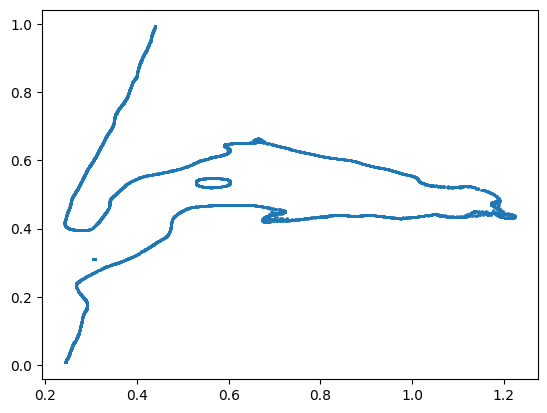

In [11]:
## Read the data :

# data = pd.read_csv("../../processed_data/normalized_domain.csv").to_numpy()
# frontier = pd.read_csv("../../processed_data/normalized_frontier.csv").to_numpy()
data = pd.read_csv("../../processed_data/Domain_height_3/normalized_domain.csv").to_numpy()
frontier = pd.read_csv("../../processed_data/Domain_height_3/normalized_frontier.csv").to_numpy()
plt.scatter(frontier[:,0],frontier[:,1],s=1)
plt.show()

In [28]:
## Choose the points :

lat = frontier[:,0].tolist()
long = frontier[:,1].tolist()

margin = 0.003
niter = 4
decrate = 0.85

for k in range(niter) :
    print('iteration : ',k+1,'out of ',niter)
    seglat = []
    seglong = []
    pbar = tqdm(total = len(lat))
    while(len(lat) >=1) :
        B=np.zeros(2)
        n=0
        A=np.array([lat[0],long[0]])
        i=0
        while i < len(lat) :
            X = np.array([lat[i],long[i]])
            if np.linalg.norm(A-X) < margin :
                lat.pop(i)
                long.pop(i)
                B+=X
                n+=1
                pbar.update(1)
            i+=1
        seglat.append(B[0]/n)
        seglong.append(B[1]/n)
    pbar.close()
    lat = seglat
    long = seglong
    margin*= decrate

print("done")
seglat=np.array(seglat)
seglong=np.array(seglong)

# plt.scatter(seglat,seglong,s=1)
# plt.show()

iteration :  1 out of  4


100%|██████████| 5892/5892 [00:11<00:00, 491.73it/s] 


iteration :  2 out of  4


100%|██████████| 1478/1478 [00:02<00:00, 508.79it/s] 


iteration :  3 out of  4


100%|██████████| 1157/1157 [00:02<00:00, 524.50it/s]


iteration :  4 out of  4


100%|██████████| 1141/1141 [00:02<00:00, 525.14it/s]

done


In [29]:
## Building segments :

segmargin = 0.008
segdic={}
seg_interdit={}
for i in tqdm(range(seglat.shape[0])) :
    if i not in segdic :
        segdic[i]=[]
    n=0
    for j in range(i,seglat.shape[0]) :
            A = np.array([seglat[i],seglong[i]])
            B = np.array([seglat[j],seglong[j]])
            if i!=j and np.linalg.norm(A-B) < segmargin :
                seg_interdit[(i,j)]=False
                seg_interdit[(j,i)]=False

                segdic[i].append(j)
                if j not in segdic :
                   segdic[j]=[]
                segdic[j].append(i)
#                 plt.plot([seglat[i],seglat[j]],[seglong[i],seglong[j]],'b')
# plt.show()

100%|██████████| 1141/1141 [00:02<00:00, 413.99it/s]


segment optimisation...
done
drawing segment...


100%|██████████| 1141/1141 [00:03<00:00, 365.58it/s]


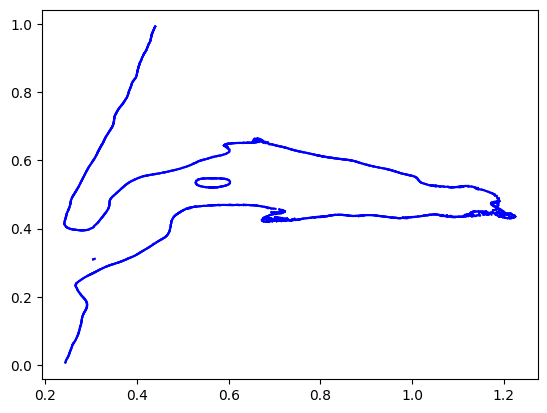

In [30]:
## Choose the final segments :

seg_final=[]

print("segment optimisation...")
for i in range(seglong.shape[0]) :
    if len(segdic)>=3 :
        neig=segdic[i]
        for j in neig :
            for k in neig :
                if k>j and j>i :
                    A = np.array([seglat[i],seglong[i]])
                    B = np.array([seglat[j],seglong[j]])
                    C = np.array([seglat[k],seglong[k]])
                    cycle = np.array([i,j,k])
                    points=np.array([A,B,C])
                    if np.linalg.norm(B-C) < segmargin :
                        Order = np.array([len(segdic[i]),len(segdic[j]),len(segdic[k])]).argsort()[::-1]
                        if Order[1] != Order[2] and len(segdic[Order[1]])>=3 :
                            cycle = cycle[Order]
                            points = points[Order]
                            if not seg_interdit[(cycle[0],cycle[1])] :
                                seg_interdit[(cycle[0],cycle[1])]=True
                                seg_interdit[(cycle[1],cycle[0])]=True

print("done")
    
print("drawing segment...")
for i in tqdm(range(seglong.shape[0])) :
    for j in range(i,seglat.shape[0]) :
        A = np.array([seglat[i],seglong[i]])
        B = np.array([seglat[j],seglong[j]])
        if i!=j and np.linalg.norm(A-B) < segmargin and not seg_interdit[(i,j)] :
            plt.plot([seglat[i],seglat[j]],[seglong[i],seglong[j]],'b')
            seg_final.append(np.concatenate((B,A)))
plt.show()

100%|██████████| 1316/1316 [00:18<00:00, 71.29it/s]


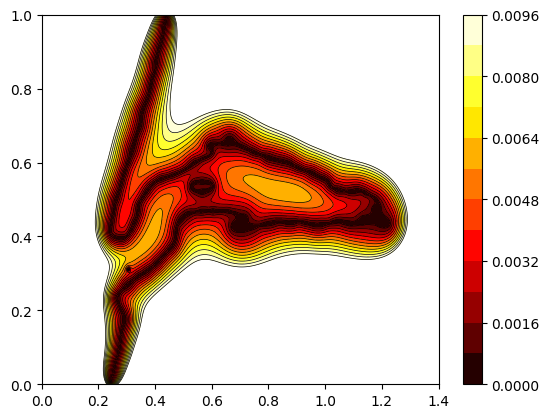

In [31]:
# drawing the function :

n=500
seg=np.array(seg_final)
x=np.linspace(0,1.4,n)
y=np.linspace(0,1,n)[::-1]
X,Y = np.meshgrid(x, y)

Z = phi(X,Y,seg)

levels = np.arange(0,0.01,0.0008)
cset = plt.contourf(X,Y,Z,levels=levels,cmap='hot')
cset2 = plt.contour(X,Y,Z,levels=levels,colors='k',linewidths=0.5)
plt.colorbar(cset)

plt.show()